Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [84]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
#import rdkit
#import sklearn

In [85]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader1 = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data1 = loader1.create_dataset('../csv_files/Polymers_Eat.csv')
loader2 = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.CircularFingerprint(size=1024))
Data2 = loader2.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [86]:
a = np.array((1,2,3),(3,4,5))
b = np.array((2,3,4))
c=np.column_stack((a,b))
pd.DataFrame(a)
pd.DataFrame(c)

,0,1
0,1,2
1,2,3
2,3,4


In [87]:
#some RDKit descriptors return nan, make these 0

X1 = np.nan_to_num(Data1.X, copy=True, nan=0.0)
print("RDKit:",X1.shape)
X2 = np.nan_to_num(Data2.X, copy=True, nan=0.0)
print("Morgan:",X2.shape)
X_data=np.column_stack((X1,X2))
print("Combined:",X_data.shape)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X_data, y=Data1.y, w=Data1.w, ids=Data1.ids, tasks = ["Eat"])

RDKit: (390, 210)
Morgan: (390, 1024)
Combined: (390, 1234)


In [88]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [101]:
#use RFE and make new dataset with selected features
#now run RFE to select the most important features 
from sklearn.feature_selection import RFE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor

selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=70, step = 100)
Selectedfeats = selector.fit_transform(Dataset.X, Dataset.y.ravel()) #y is a colum vector but it needs a 1d array -> ravel fixes this
selected = selector.support_ #this returns an array with true and false True are the selected features
RFEDataset = dc.data.DiskDataset.from_numpy(X=Selectedfeats, y=Data1.y, w=Data1.w, ids=Data1.ids, tasks = ["Eat"])

#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(RFEDataset)
RFEDataset

<DiskDataset X.shape: (390, 70), y.shape: (390, 1), w.shape: (390, 1), ids: ['[*]CC([*])C' '[*]CC([*])F' '[*]CC([*])(F)F' ...
 '[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]' '[*]C(F)(F)OC(F)(F)O[*]'
 '[*]N(C(=O)C1=C2)C(=O)C1=CC=C2C(=O)C(=CC=C3C4(=O))C=C3C(=O)N4C(C)COCCOCCOC(C)COCC(C)[*]'], task_names: ['Eat']>

In [96]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted


In [97]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999999999922}
Test set score: {'pearson_r2_score': 0.9632152735152644}


In [98]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 9.917198441737454e-16}
Test set score: {'mean_squared_error': 0.004629278222437468}


In [99]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))

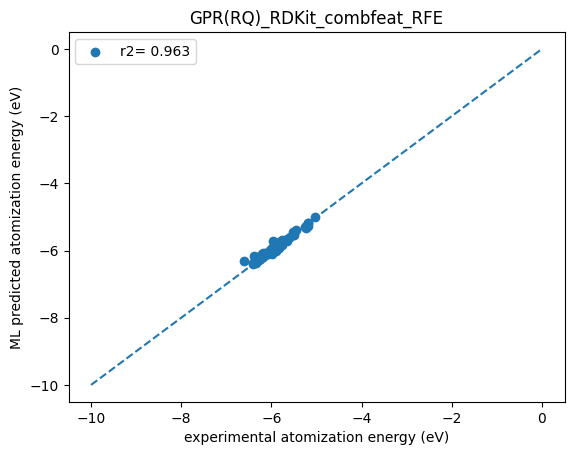

In [100]:
#plot the data
import matplotlib.pyplot as plt

x=[-10,0]
y=[-10,0]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental atomization energy (eV)")
plt.ylabel("ML predicted atomization energy (eV)")
plt.title("GPR(RQ)_RDKit_combfeat_RFE")
plt.show()
